In [1]:
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.exceptions import DataConversionWarning
from pandas import set_option

In [155]:
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
import xgboost
import torch
import torch.nn as nn
import torch.optim as optim
import copy,math

In [281]:
def missing_zero_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([ mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0: 'Missing Values', 1 : '% of Total Values'})
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table.sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
        "There are " + str(mz_table.shape[0]) +
          " columns that have missing values.")
    return mz_table

def RemoveOutlier(df, features = [], qtl_min = 0.01, qtl_max = 0.99):
    info_CAP = dict()
    for nameFeature in features:
        q_max = df[nameFeature].quantile(0.99)
        q_min = df[nameFeature].quantile(0.01)
        info_CAP[nameFeature] = (q_min, q_max)
        df.loc[:, nameFeature] = df[nameFeature].apply(lambda x: q_min if x < q_min else q_max if x > q_max else x)
    return df, info_CAP

def find_optimal_cutoff(target, predict):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = metrics.roc_curve(target, predict)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({"tpr" : pd.Series(tpr, index=i), "fpr" : pd.Series(fpr, index=i), 'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return roc_t.to_dict('records')[0]

## 1. Data Load

### data path

In [3]:
path_data = r"C:\Users\xiaoyaohou\Documents\Aquant\Risk\data"

### data dictionary

In [4]:
pd.set_option('display.max_colwidth', None)
data_dict = pd.read_excel(os.path.join(path_data, 'Data Dictionary.xls'), header=1)
data_dict

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


### load data

In [5]:
train = pd.read_csv(os.path.join(path_data, 'cs-training.csv'))
train.rename(columns={'Unnamed: 0': "id"},inplace = True)
test = pd.read_csv(os.path.join(path_data, 'cs-test.csv'))
test.rename(columns={'Unnamed: 0': "id"},inplace = True)
train.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
test.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


## 2. Data Preprocess

### missing rate check 

In [7]:
missing_zero_values_table(train)

Your selected dataframe has 12 columns and 150000 Rows.
There are 12 columns that have missing values.


,Missing Values,% of Total Values,Data Type
MonthlyIncome,29731,19.8,float64
NumberOfDependents,3924,2.6,float64
id,0,0.0,int64
SeriousDlqin2yrs,0,0.0,int64
RevolvingUtilizationOfUnsecuredLines,0,0.0,float64
age,0,0.0,int64
NumberOfTime30-59DaysPastDueNotWorse,0,0.0,int64
DebtRatio,0,0.0,float64
NumberOfOpenCreditLinesAndLoans,0,0.0,int64
NumberOfTimes90DaysLate,0,0.0,int64


In [8]:
missing_zero_values_table(test)

Your selected dataframe has 12 columns and 101503 Rows.
There are 12 columns that have missing values.


,Missing Values,% of Total Values,Data Type
SeriousDlqin2yrs,101503,100.0,float64
MonthlyIncome,20103,19.8,float64
NumberOfDependents,2626,2.6,float64
id,0,0.0,int64
RevolvingUtilizationOfUnsecuredLines,0,0.0,float64
age,0,0.0,int64
NumberOfTime30-59DaysPastDueNotWorse,0,0.0,int64
DebtRatio,0,0.0,float64
NumberOfOpenCreditLinesAndLoans,0,0.0,int64
NumberOfTimes90DaysLate,0,0.0,int64


### data distribution check and outlier check
- RevolvingUtilizationOfUnsecuredLines data has some extreme outliers
- age field should not contain data that less than 18 ?
- 

#### remove outliers

In [9]:
features = train.columns[2:]
train, info_CAP = RemoveOutlier(df = train, features= features)

C:\Users\xiaoyaohou\AppData\Local\Temp\ipykernel_21428\3107640654.py:21: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, nameFeature] = df[nameFeature].apply(lambda x: q_min if x < q_min else q_max if x > q_max else x)


#### data distribution

In [10]:
train.describe(percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,120269.000000,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,0.320496,52.279260,0.245860,316.548869,6349.112332,8.404000,0.086487,0.992600,0.063180,0.747700
std,43301.414527,0.249746,0.352152,14.668105,0.666815,906.962222,4358.376183,4.946399,0.401673,0.985802,0.290107,1.077946
min,1.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,1500.990000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,7500.950000,0.000000,0.000000,29.000000,0.000000,0.004329,1300.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3400.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5400.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8249.000000,11.000000,0.000000,2.000000,0.000000,1.000000
95%,142500.050000,1.000000,1.000000,78.000000,2.000000,2449.000000,14587.600000,18.000000,1.000000,3.000000,1.000000,3.000000


In [11]:
test.describe(percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,101503.000000,0.0,101503.000000,101503.000000,101503.000000,101503.000000,8.140000e+04,101503.000000,101503.000000,101503.000000,101503.000000,98877.000000
mean,50752.000000,NaN,5.310000,52.405436,0.453770,344.475020,6.855036e+03,8.453514,0.296691,1.013074,0.270317,0.769046
std,29301.536524,NaN,196.156039,14.779756,4.538487,1632.595231,3.650860e+04,5.144100,4.515859,1.110253,4.503578,1.136778
min,1.000000,NaN,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1%,1016.020000,NaN,0.000000,24.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
5%,5076.100000,NaN,0.000000,29.000000,0.000000,0.004383,1.340950e+03,2.000000,0.000000,0.000000,0.000000,0.000000
25%,25376.500000,NaN,0.030131,41.000000,0.000000,0.173423,3.408000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,50752.000000,NaN,0.152586,52.000000,0.000000,0.364260,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,76127.500000,NaN,0.564225,63.000000,0.000000,0.851619,8.200000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
95%,96427.900000,NaN,1.000000,78.000000,2.000000,2435.000000,1.456810e+04,18.000000,1.000000,3.000000,1.000000,3.000000


#### data distribution visualization

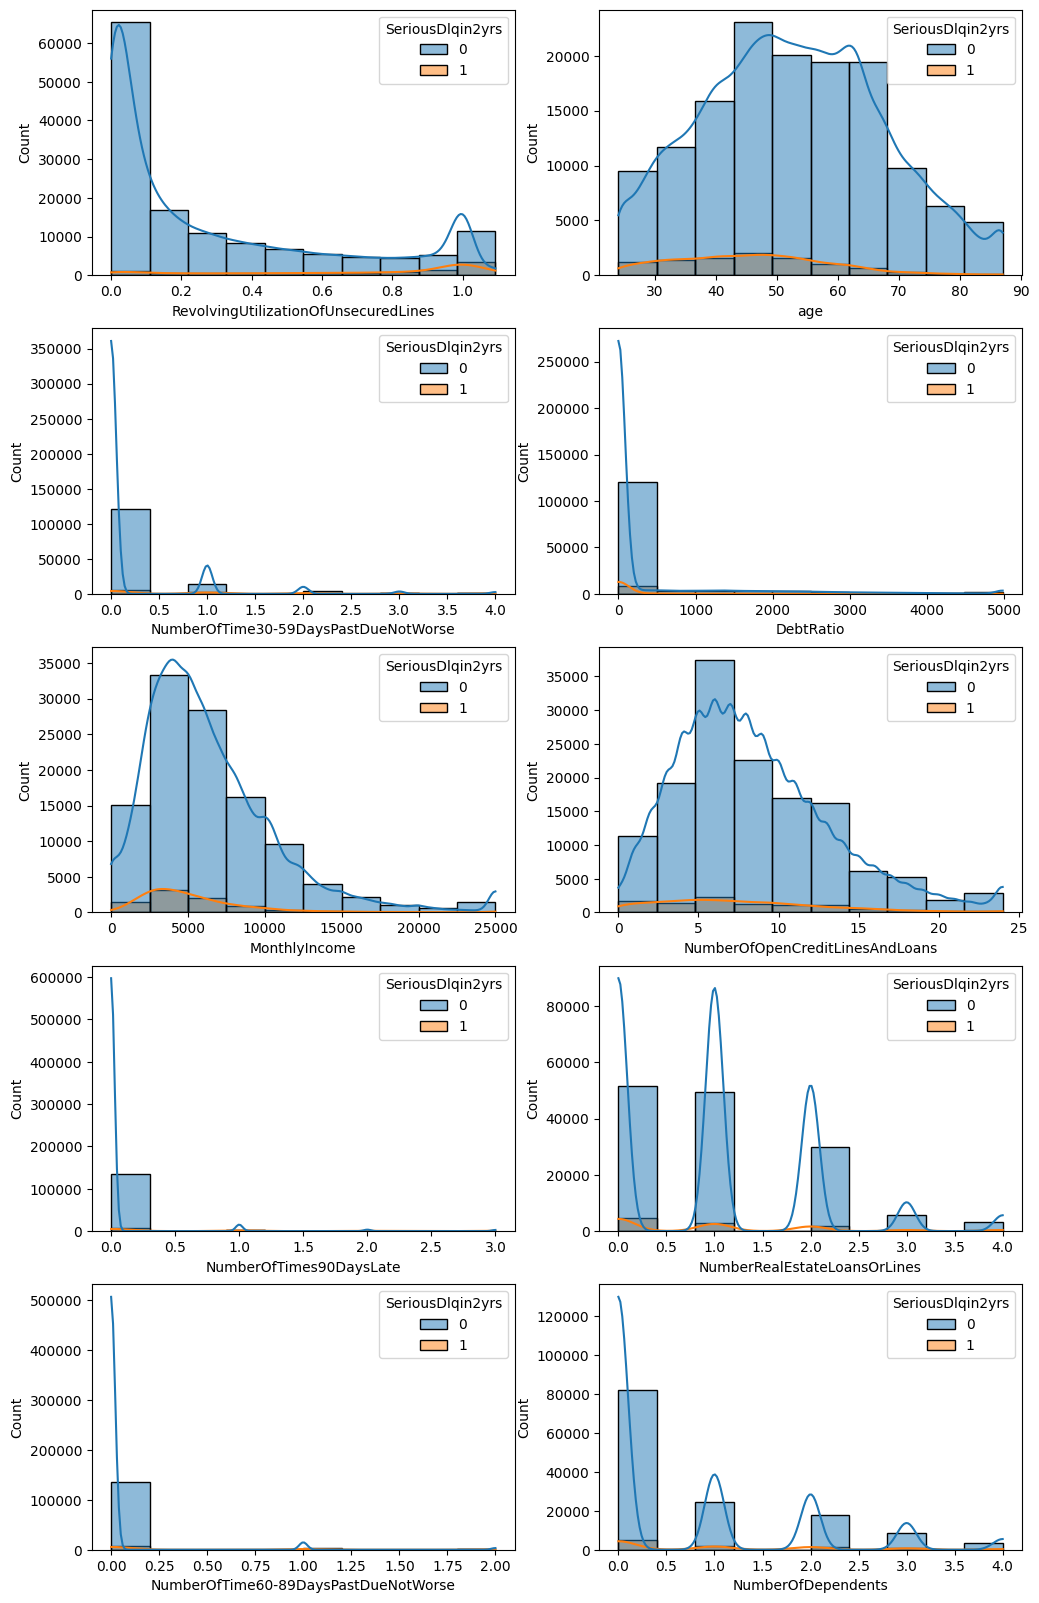

In [215]:
nr = len(features)//2 + len(features)%2
fig, axs = plt.subplots(nr, 2, figsize=(12, 4 * nr))
for c, col in enumerate(features):
    sns.histplot(data=train, x=col, bins = 10, kde=True, color="skyblue", hue="SeriousDlqin2yrs", ax=axs[c//2, c%2])
plt.show()

### null value imputation

#### abnrmal value imputation

In [13]:
train.loc[train['age'] == 0,'age'] = np.nan

In [14]:
train["age"].min()

24.0

#### preprocess data with scaler and Imputers

In [15]:
preprocess = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', KNNImputer(n_neighbors=10, weights= "distance"))
])

In [16]:
train_preprocess = preprocess.fit_transform(train[features])

#### get the imputed & unscaled data

In [17]:
train_preprocess_reverse = preprocess["scaler"].inverse_transform(train_preprocess)
train_preprocess_noscale = pd.DataFrame(train_preprocess_reverse, columns = features)
train_preprocess_noscale = pd.concat([train.iloc[:, :2], train_preprocess_noscale], axis = 1)

### Customer Profile

- Customer # of train data is 150,000 while no gender info
>
- Customer average age 52 while min age is 24 (21 for test data)
- For NumberOfDependents, the median value is 0 while only 41% of the customers have GTE 1 dependents. Considering the avg age is 52, this is not very reasonable. A little suspicious about the data source, the data maybe input by the customers themselves.
- For MonthlyIncome, the median value is 4,400 while average is 5,154
- For DebtRatio, the median value is 36.6% (Assume the unit here is not percentage)
- For NumberOfOpenCreditLinesAndLoans, the median and avg value is 8 
- For RevolvingUtilizationOfUnsecuredLines, the median value is 15% which while avg is 30%. This means there are heavy CreditCard users
>
- For NumberOfTime30-59DaysPastDueNotWorse, there is 23.6% customers have GTE 1 times
- For NumberOfTime60-89DaysPastDueNotWorse, there is 7.5% customers have GTE 1 times
- For NumberOfTimes90DaysLate, there is 8.2% customers have GTE 1 times



In [334]:
train_preprocess_noscale[train_preprocess_noscale["NumberOfTime30-59DaysPastDueNotWorse"] > 0].shape[0] * 1.0 / 150000

0.15988

In [335]:
train_preprocess_noscale[train_preprocess_noscale["NumberOfTime60-89DaysPastDueNotWorse"] > 0].shape[0] * 1.0 / 150000

0.05069333333333333

In [336]:
train_preprocess_noscale[train_preprocess_noscale["NumberOfTimes90DaysLate"] > 0].shape[0] * 1.0 / 150000

0.055586666666666666

In [337]:
train_preprocess_noscale[train_preprocess_noscale["NumberOfDependents"] > 0].shape[0] * 1.0 / 150000

0.41224

#### train-validate data split

In [71]:
X_train, X_validate, y_train, y_validate = train_test_split(train_preprocess_noscale[features], train_preprocess_noscale["SeriousDlqin2yrs"], test_size = 0.3, random_state=18)

## 3. XGBoost Model

### Model Train

In [72]:
#X_train = train_preprocess_noscale.loc[:, features].to_numpy()
#y_train = train_preprocess_noscale.loc[:, ].to_numpy()

# Define the parameter grid for ExtraTreesClassifier
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

# Create an ExtraTreesClassifier instance
model = XGBClassifier()

# Create a RandomizedSearchCV instance for ExtraTreesClassifier
xgb = RandomizedSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    n_iter=32,  # Adjust the number of iterations as needed
    verbose=1,
    random_state=42
)

# Fit the model
xgb.fit(X_train, y_train)
y_pred_train = xgb.predict_proba(X_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


#### feature importance

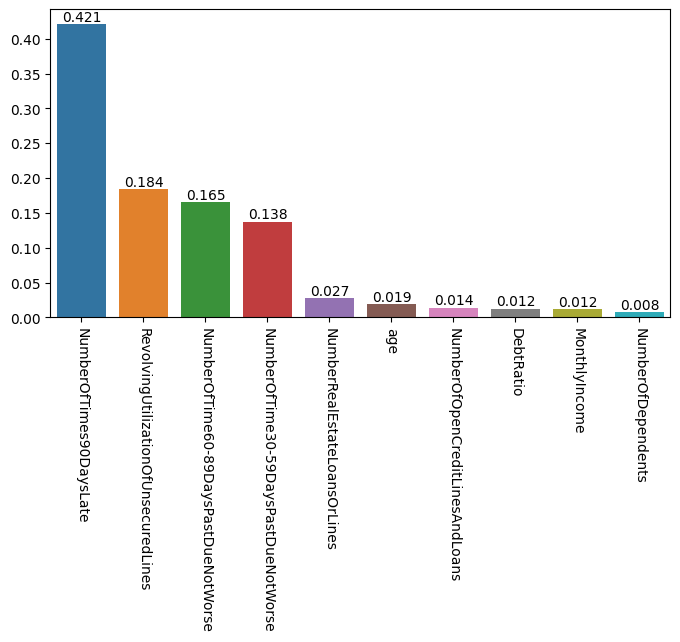

In [79]:
_, ax = plt.subplots(figsize=(8, 4))
importance_features = dict(zip(features, xgb.best_estimator_.feature_importances_))
importance_features = dict(sorted(importance_features.items(), key=lambda x:x[1], reverse= True))
sns.barplot(x = list(importance_features.keys()), y = list(importance_features.values()))
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')
plt.xticks(rotation=-90)
plt.show()

We can see from the Xgboost feature importance that 
- 1. "NumberOfTimes90DaysLate" "NumberOfTime60-89DaysPastDueNotWorse" "NumberOfTime30-59DaysPastDueNotWorse" is very important for the classifier, this means once the customer was late due to the debt, the customer is very likely to be late again, especially 90 days late.
- 2. "RevolvingUtilizationOfUnsecuredLines" is also important to identify the high-risk customers
- 3. About the data confidence, we need to get the data source of all columns, especially MonthlyIncome and NumberOfDependents 

#### ROC curve

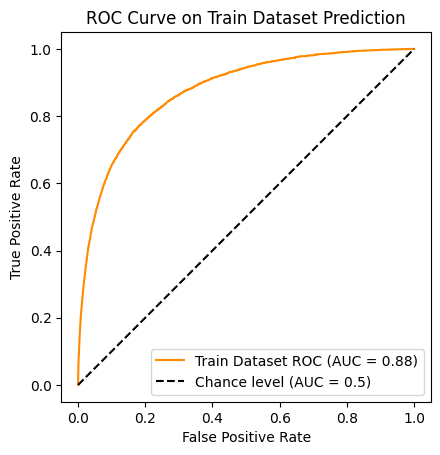

AUC of the model prediction on Train data is 0.8752


In [85]:
RocCurveDisplay.from_predictions(y_true=y_train,
    y_pred= y_pred_train[:, 1],
    name=f"Train Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = y_train, y_score = y_pred_train[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Train Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Train data is {auc:.4f}")

### Check if we select the optimal cutting point threshold to select top N customers as potential bad customers 

In [293]:
#### get the optimal cutoff threshhold
info_cutoff = find_optimal_cutoff(target = y_train, predict = y_pred_train[:, 1])

#### make the data train 
data_train = pd.concat([X_train, y_train], axis = 1)
data_train.loc[:, "xgb_pred"] = y_pred_train[:, 1]
data_train_cutoff = data_train[data_train["xgb_pred"] > info_cutoff["threshold"]]

#### get precision of the prediction
precision_train = data_train_cutoff.shape[0] * 1.0 / data_train.shape[0]
print(f"precision of the Top predict train data is {precision_train * 100.0:.2f}%")

precision of the Top predict train data is 24.62%


In [339]:
info_cutoff

{'tpr': 0.7936128306133934,
 'fpr': 0.20647243901442405,
 'tf': 8.52696278174081e-05,
 'threshold': 0.06589467078447342}

<b>Findings:
- The current precision 24.62% is not high enough to filter out the high-risk potential bad customers
- If we select the best cutoff point, we can cover ~80% of all bad customers while 20% of good customers will be wrongly labeled.

Fitting 5 folds for each of 32 candidates, totalling 160 fits


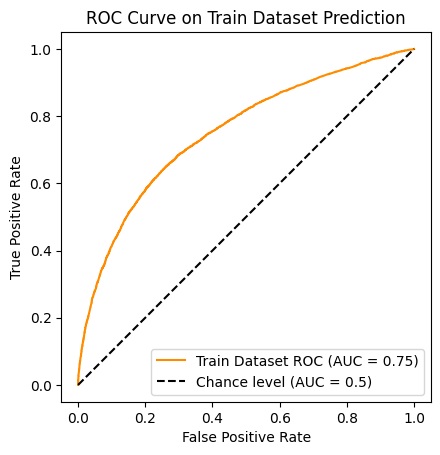

AUC of the model prediction on Train data is 0.7515


In [319]:
X_train_cutoff = data_train_cutoff.loc[:, features].to_numpy()
y_train_cutoff = data_train_cutoff.loc[:,"SeriousDlqin2yrs" ].to_numpy()

# Create an ExtraTreesClassifier instance
model_train_cutoff = XGBClassifier()

# Create a RandomizedSearchCV instance for ExtraTreesClassifier
xgb_train_cutoff = RandomizedSearchCV(
    model_train_cutoff,
    param_grid,
    scoring='average_precision',
    cv=5,
    n_jobs=-1,
    n_iter=32,  # Adjust the number of iterations as needed
    verbose=1,
    random_state=42
)

# Fit the model
xgb_train_cutoff.fit(X_train_cutoff, y_train_cutoff)
y_pred_train_cutoff = xgb_train_cutoff.predict_proba(X_train_cutoff)

RocCurveDisplay.from_predictions(y_true=y_train_cutoff,
    y_pred= y_pred_train_cutoff[:, 1],
    name=f"Train Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = y_train_cutoff, y_score = y_pred_train_cutoff[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Train Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Train data is {auc:.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


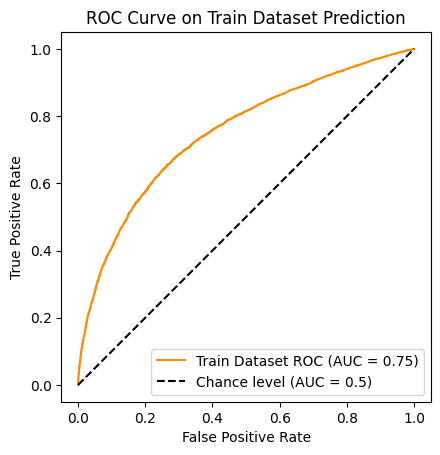

AUC of the model prediction on Train data is 0.7501


In [338]:
X_train_cutoff = data_train_cutoff.loc[:, features].to_numpy()
y_train_cutoff = data_train_cutoff.loc[:,"SeriousDlqin2yrs" ].to_numpy()

# Create an ExtraTreesClassifier instance
model_train_cutoff = XGBClassifier()

# Create a RandomizedSearchCV instance for ExtraTreesClassifier
xgb_train_cutoff = RandomizedSearchCV(
    model_train_cutoff,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    n_iter=32,  # Adjust the number of iterations as needed
    verbose=1,
    random_state=42
)

# Fit the model
xgb_train_cutoff.fit(X_train_cutoff, y_train_cutoff)
y_pred_train_cutoff = xgb_train_cutoff.predict_proba(X_train_cutoff)

RocCurveDisplay.from_predictions(y_true=y_train_cutoff,
    y_pred= y_pred_train_cutoff[:, 1],
    name=f"Train Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = y_train_cutoff, y_score = y_pred_train_cutoff[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Train Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Train data is {auc:.4f}")

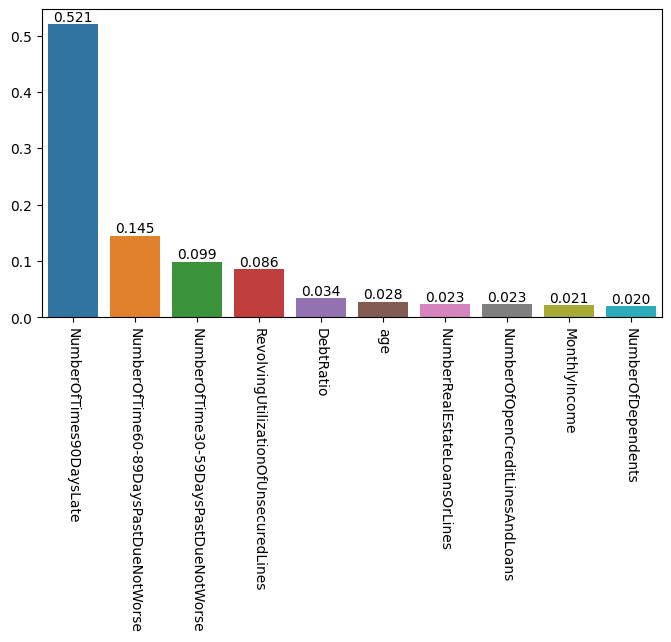

In [302]:
_, ax = plt.subplots(figsize=(8, 4))
importance_features = dict(zip(features, xgb_train_cutoff.best_estimator_.feature_importances_))
importance_features = dict(sorted(importance_features.items(), key=lambda x:x[1], reverse= True))
sns.barplot(x = list(importance_features.keys()), y = list(importance_features.values()))
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')
plt.xticks(rotation=-90)
plt.show()


epoch - 0 : 0.7584842987531839

epoch - 1 : 0.6355115924925767

epoch - 2 : 0.6199521571397781

epoch - 3 : 0.6058513087819714

epoch - 4 : 0.5948818111142447

epoch - 5 : 0.5828037075987158

epoch - 6 : 0.5938471504884173

epoch - 7 : 0.6164391605659972

epoch - 8 : 0.6299170014239097

epoch - 9 : 0.5705895058868468

epoch - 10 : 0.6372450256301451

epoch - 11 : 0.5807662536931593

epoch - 12 : 0.6170308133659437

epoch - 13 : 0.6070900052323822

epoch - 14 : 0.5706646872121234

epoch - 15 : 0.6081866775603257

epoch - 16 : 0.5965827731199043

epoch - 17 : 0.5565259479737097

epoch - 18 : 0.5993188981168954

epoch - 19 : 0.5631746132244435

epoch - 20 : 0.6279666759940081

epoch - 21 : 0.5588829088811726

epoch - 22 : 0.5950738967851151

epoch - 23 : 0.5993613674659137

epoch - 24 : 0.5484264592329661

epoch - 25 : 0.5812096990818201

epoch - 26 : 0.5821825895429582

epoch - 27 : 0.5450750513132229

epoch - 28 : 0.5759677945874458

epoch - 29 : 0.5912498031244722

epoch - 30 : 0.5498

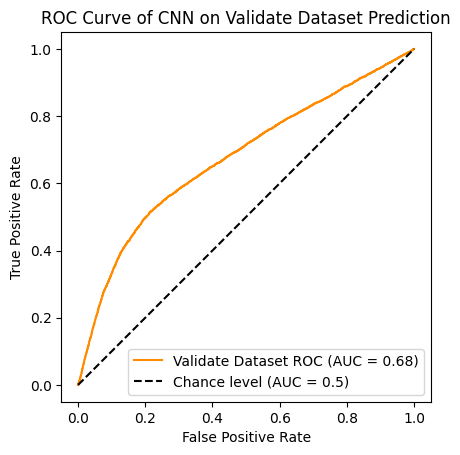

AUC of the model prediction on Validate data is 0.6752


In [318]:
tX_train_cutoff = torch.from_numpy(X_train_cutoff).unsqueeze(1).float()
ty_train_cutoff = torch.from_numpy(y_train_cutoff).float()

criterion = nn.BCELoss()
learning_rt = 0.1
cnn_train_cutoff  = CNNNet(n_feature = 10)
optimizer = optim.RMSprop(cnn_train_cutoff.parameters(), lr=learning_rt)

batch_size = 100
epoches = 100
cnn_train_cutoff.train()
for epoch in range(epoches):
    print()
    ls_loss = []
    for n_batch in range(tX_train_cutoff.size(0)//batch_size):
        batch_tX_train = tX_train_cutoff[n_batch:n_batch+batch_size, :, :].clone().detach()
        batch_ty_train = ty_train_cutoff[n_batch:n_batch+batch_size].clone().detach()
        batch_pred  = cnn_train_cutoff(batch_tX_train)
        loss = criterion(batch_pred[:, 1], batch_ty_train)
        ls_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"epoch - {epoch} : {np.mean(ls_loss)}")

cnn_train_cutoff.eval()
validate_pred_cutoff  = cnn_train_cutoff(tX_train_cutoff)

RocCurveDisplay.from_predictions(y_true=ty_train_cutoff,
    y_pred= validate_pred_cutoff[:, 1].detach().numpy(),
    name=f"Validate Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = ty_train_cutoff, y_score = validate_pred_cutoff[:, 1].detach().numpy(), pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of CNN on Validate Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Validate data is {auc:.4f}")

### Model Validation

#### ROC-AUC Curve

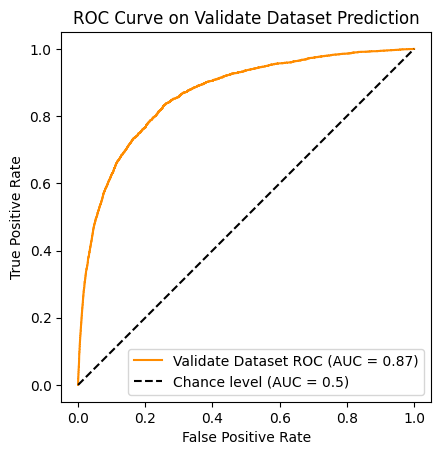

AUC of the model prediction on Validate data is 0.8654


In [219]:
y_pred_validate = xgb.predict_proba(X_validate)
RocCurveDisplay.from_predictions(y_true=y_validate,
    y_pred= y_pred_validate[:, 1],
    name=f"Validate Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = y_validate, y_score = y_pred_validate[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Validate Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Validate data is {auc:.4f}")

#### Confusion Matrix Analysis
- Assume that we label top 10% high-risk customers as Bad customers

In [282]:
#### get the optimal cutoff point
info_cutoff = find_optimal_cutoff(target = y_validate, predict = y_pred_validate[:, 1])

In [283]:
info_cutoff

{'tpr': 0.7858122001370802,
 'fpr': 0.21417708283826814,
 'tf': -1.0717024651718532e-05,
 'threshold': 0.06414828449487686}

In [284]:
data_validate = pd.concat([X_validate, y_validate], axis = 1)
data_validate.loc[:, "xgb_pred"] = y_pred_validate[:, 1]
nv_row, nv_col = data_validate.shape
data_validate_cutoff = data_validate[data_validate["xgb_pred"] > info_cutoff["threshold"]]

In [285]:
data_validate_cutoff.shape[0] * 1.0 / data_validate.shape[0]

0.25122222222222224

In [286]:
data_validate_cutoff["SeriousDlqin2yrs"].sum() * 1.0 / data_validate_cutoff.shape[0]

0.20283060592658117

In [235]:
thresholds[:100]

array([       inf, 0.91508627, 0.87104696, 0.8701808 , 0.86701137,
       0.865762  , 0.8612471 , 0.85713446, 0.8566431 , 0.8565649 ,
       0.83984864, 0.8337756 , 0.83354783, 0.8317024 , 0.8221765 ,
       0.82213944, 0.819338  , 0.8191832 , 0.81152046, 0.8098855 ,
       0.8036189 , 0.80343264, 0.80205643, 0.8016689 , 0.797823  ,
       0.7968574 , 0.79493773, 0.7925767 , 0.7916747 , 0.79126585,
       0.790688  , 0.7890575 , 0.788537  , 0.787423  , 0.7866545 ,
       0.78463197, 0.78391874, 0.7812362 , 0.7799942 , 0.77992225,
       0.7774774 , 0.7774346 , 0.7764179 , 0.7761694 , 0.774786  ,
       0.7737683 , 0.7723917 , 0.77179533, 0.7710035 , 0.770919  ,
       0.76901656, 0.76767105, 0.764914  , 0.76272076, 0.7609309 ,
       0.7606218 , 0.7592722 , 0.7576808 , 0.7550198 , 0.7550085 ,
       0.75241   , 0.7524028 , 0.7500678 , 0.7488607 , 0.7484012 ,
       0.7482636 , 0.74647295, 0.746077  , 0.74505985, 0.7434812 ,
       0.74226063, 0.74041814, 0.74031335, 0.740214  , 0.73905

### Model TEST

In [81]:
test_preprocess = preprocess.transform(test[features])
test_preprocess_reverse = preprocess["scaler"].inverse_transform(test_preprocess)
test_preprocess_noscale = pd.DataFrame(test_preprocess_reverse, columns = features)
test_preprocess_noscale = pd.concat([test.iloc[:, :2], test_preprocess_noscale], axis = 1)
X_test = test_preprocess_noscale.loc[:, features].to_numpy()
y_test = test_preprocess_noscale.loc[:, "SeriousDlqin2yrs"].to_numpy()
# Fit the model
y_pred_test = xgb.predict_proba(X_test)
test.iloc[:, 1] = y_pred_test[:, 1]

C:\Users\xiaoyaohou\AppData\Local\Temp\ipykernel_21428\1475909220.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.iloc[:, 1] = y_pred_test[:, 1]


In [83]:
test.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.063722,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,0.061421,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,0.013653,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,0.105393,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,0.119930,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


### 4. CNN Model

In [198]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
 
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class CNNNet(nn.Module):
    def __init__(self, n_feature,  dropout = 0.1):
        super(CNNNet, self).__init__()
        # Layer 1
        self.dropout = nn.Dropout(dropout)
        self.layers = clones(nn.Conv1d(1, 10, 10, padding = 0), 3)
        self.norm = LayerNorm(n_feature)
        self.f1 = nn.Linear(10, 2)
        
    def forward(self, x):
        for layer in self.layers:
            # x = x + self.norm(self.dropout(layer(x).transpose(-2, -1)))
            x = self.norm(self.dropout(layer(x).transpose(-2, -1)))
        out1 = x.contiguous().view(x.size(0), -1)
        out2 = self.f1(out1).softmax(dim=-1)
        # return x + self.dropout(sublayer(self.norm(x)))
        return out2

#### 4.1 Train-Validate data split for preprocessed train data

In [160]:
tX_train, tX_validate, ty_train, ty_validate = train_test_split(train_preprocess, train.loc[:,"SeriousDlqin2yrs"].to_numpy(), test_size = 0.3, random_state=18)

# turn into Tensors
tX_train = torch.Tensor(tX_train).unsqueeze(1)
ty_train = torch.Tensor(ty_train)
tX_validate = torch.Tensor(tX_validate).unsqueeze(1)

#### 4.2 model build

In [211]:
criterion = nn.BCELoss()
learning_rt = 0.1
cnn  = CNNNet(n_feature = 10)
optimizer = optim.RMSprop(cnn.parameters(), lr=learning_rt)

#### 4.3 model train

In [212]:
batch_size = 1000
epoches = 100
cnn.train()
for epoch in range(epoches):
    print()
    ls_loss = []
    for n_batch in range(tX_train.size(0)//batch_size):
        batch_tX_train = tX_train[n_batch:n_batch+batch_size, :, :].clone().detach()
        batch_ty_train = ty_train[n_batch:n_batch+batch_size].clone().detach()
        batch_pred  = cnn(batch_tX_train)
        loss = criterion(batch_pred[:, 1], batch_ty_train)
        ls_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"epoch - {epoch} : {np.mean(ls_loss)}")


epoch - 0 : 1.2489587626286915

epoch - 1 : 0.2649073426212583

epoch - 2 : 0.2559088604790824

epoch - 3 : 0.24620576018378848

epoch - 4 : 0.2358665325811931

epoch - 5 : 0.2245210140943527

epoch - 6 : 0.21896229414712814

epoch - 7 : 0.21301626676604862

epoch - 8 : 0.2078513652086258

epoch - 9 : 0.20363586360499972

epoch - 10 : 0.20133898031143915

epoch - 11 : 0.20179173861231123

epoch - 12 : 0.20069620524133955

epoch - 13 : 0.3688915455625171

epoch - 14 : 0.20508842156046914

epoch - 15 : 0.1990764292932692

epoch - 16 : 0.19657517075538636

epoch - 17 : 0.19976923494111923

epoch - 18 : 0.19267025121620723

epoch - 19 : 0.2968895265034267

epoch - 20 : 0.19159760829948244

epoch - 21 : 0.19487595018886383

epoch - 22 : 0.22180559777078174

epoch - 23 : 0.1926319190434047

epoch - 24 : 0.18918813921156383

epoch - 25 : 0.19848953031358266

epoch - 26 : 0.19033534399100713

epoch - 27 : 0.19213998402868

epoch - 28 : 0.20577724746295384

epoch - 29 : 0.18050900953156607

ep

#### 4.4 model validate

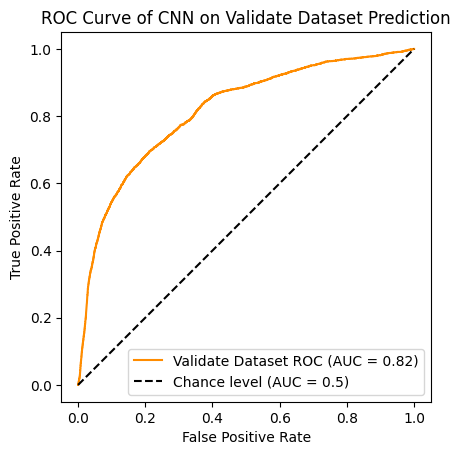

AUC of the model prediction on Validate data is 0.8153


In [213]:
cnn.eval()
validate_pred  = cnn(tX_validate)

RocCurveDisplay.from_predictions(y_true=ty_validate,
    y_pred= validate_pred[:, 1].detach().numpy(),
    name=f"Validate Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = ty_validate, y_score = validate_pred[:, 1].detach().numpy(), pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of CNN on Validate Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Validate data is {auc:.4f}")

In [243]:
fpr, tpr, threshold = metrics.roc_curve(y_true = ty_validate, y_score = validate_pred[:, 1].detach().numpy())

In [251]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({"tpr" : pd.Series(tpr, index=i), "fpr" : pd.Series(fpr, index=i), 'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})

In [252]:
roc

,tpr,fpr,tf,threshold
0,0.000000,0.000000,-1.000000,inf
1,0.000000,0.000024,-0.999976,0.923635
2,0.000000,0.000238,-0.999762,0.879786
3,0.000343,0.000238,-0.999420,0.876395
4,0.000343,0.000261,-0.999396,0.873792
...,...,...,...,...
5073,0.999315,0.997220,0.996534,0.000086
5074,0.999657,0.997220,0.996877,0.000086
5075,0.999657,0.997457,0.997115,0.000086
5076,1.000000,0.997457,0.997457,0.000086


In [249]:
(roc.tf-0).abs().argsort()[:1]

0    3298
Name: tf, dtype: int64

In [250]:
(roc.tf-0).abs().argsort()

0       3298
1       3299
2       3297
3       3300
4       3301
        ... 
5073       3
5074       2
5075       1
5076       0
5077    5077
Name: tf, Length: 5078, dtype: int64

In [253]:
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

In [254]:
roc_t

,tpr,fpr,tf,threshold
3298,0.735435,0.264531,-0.000034,0.01545
